In [1]:
import csv
import subprocess
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
class Experiment:
    def __init__(self, functions_file, optimization_file):
        self.functions_file = functions_file
        self.optimization_file = optimization_file
        self.functions_param=[]
        self.optimization_param=[]
        
        
        self.f_param_list_function_id=[]
        self.f_param_list_name=[]
        self.f_param_list_range_low=[]
        self.f_param_list_range_high=[]
        self.f_param_list_dimensions_vector=[]
            
        self.opt_param_list_id = []
        self.opt_param_list_name = []
        self.opt_param_list_config_file = []
            
        self.readFunctionsFile()
        self.readOptimizationFile()
        self.solution_file = 'solutions.csv'
        self.solution_df = None
        
    def readFunctionsFile(self):
        with open(self.functions_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.functions_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.functions_param)):
            self.f_param_list_function_id.append(self.functions_param[i][0]) #function_id
            self.f_param_list_name.append(self.functions_param[i][1]) # function name
            self.f_param_list_range_low.append(self.functions_param[i][2]) # range low
            self.f_param_list_range_high.append(self.functions_param[i][3]) # range high
            self.f_param_list_dimensions_vector.append(self.functions_param[i][4:]) # dimension vector, from 4 to the last element
            
    def readOptimizationFile(self):
        with open(self.optimization_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.optimization_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.optimization_param)):
            self.opt_param_list_id.append(self.optimization_param[i][0]) #opt algorithm id
            self.opt_param_list_name.append(self.optimization_param[i][1]) #algo name
            self.opt_param_list_config_file.append(self.optimization_param[i][2]) # config file
            
    def delete_all_output_files(self):
        files = glob.glob('a*.csv')
        for f in files:
            os.remove(f)
            
    def merge_all_output_files(self):
        files = glob.glob("./a*.csv")
        #print(files)
        solutions=[]
        for f in files:
            with open(f) as csvfile:
                read_csv = csv.reader(csvfile, delimiter=',')
                for i,row in enumerate(read_csv):
                    if i != 0: # first row
                        solutions.append(row)
        #print(solutions)
        
        
        with open(self.solution_file, mode='w') as solution_file:
            writer = csv.writer(solution_file, delimiter=',', lineterminator='\n',quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['algorithm_id'
                             ,'function_id'
                             ,'n_runs'
                             ,'dimensions'
                             ,'range_low'
                             ,'range_high'
                             ,'mean'
                             ,'std_dev'
                             ,'range'
                             ,'median'
                             ,'time_ms'
                             ,'range_min'
                             ,'range_max'
                            ])
            writer.writerows(solutions)
            
    def plot(self):
        df=pd.read_csv('solutions.csv',index_col=False)
        df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
        self.solution_df = df
        
        #-----------plot running time
        fig, ax = plt.subplots(figsize=(8,6))
        for label, data in df.groupby('algorithm_id'):
            data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
        plt.ylabel('time [ms]')    
        plt.legend()
        plt.grid()
        plt.title('Running time')
        
   
        #---------plot statistics
        for id, data in df.groupby('function_id'):
            fig, ax = plt.subplots(figsize=(8,4))
            plt.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
            plt.plot(data['algorithm_id'],data['median'],label='median')
            plt.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
            plt.xticks(data['algorithm_id'])
            plt.title("f%d : %s"%(id, self.f_param_list_name[id-1]))
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xlabel('algorithm_id')
            plt.ylabel('solution')
            plt.grid()
        

    def run(self, n_runs):
        
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.Popen([
                                    "../bin/debug/project.exe"
                                    #"../bin/release/project.o"
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            # wait every process to finish
            for p in process_list:
                p.wait()
            print("----finished----alg: %d"%k)
        
        self.merge_all_output_files()
        #delete all temp files
        self.delete_all_output_files()

In [34]:
test = Experiment('../config/function_list.csv', '../config/optimization_alg_list.csv') 

In [35]:
test.opt_param_list_name

['GA',
 'DE_best_1_exp',
 'DE_rand_1_exp',
 'DE_randbest_1_exp',
 'DE_best_2_exp',
 'DE_rand_2_exp',
 'DE_best_1_bin',
 'DE_rand_1_bin',
 'DE_randbest_1_bin',
 'DE_best_2_bin',
 'DE_rand_2_bin']

In [38]:
test.run(15) # n runs

----finished----alg: 0
----finished----alg: 1
----finished----alg: 2
----finished----alg: 3
----finished----alg: 4
----finished----alg: 5
----finished----alg: 6
----finished----alg: 7
----finished----alg: 8
----finished----alg: 9
----finished----alg: 10


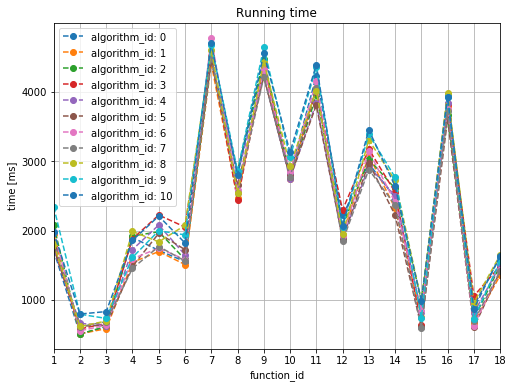

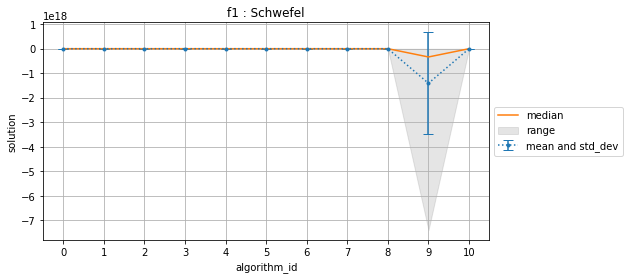

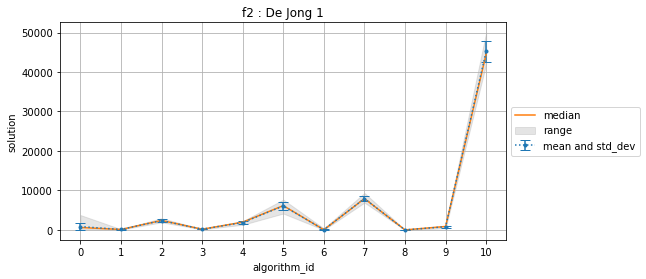

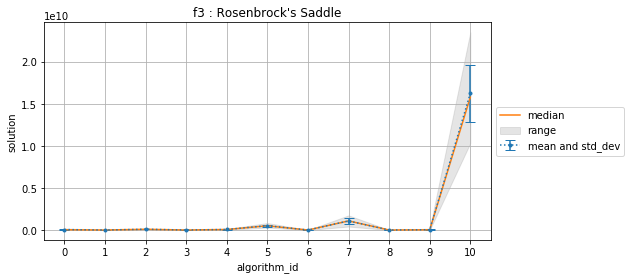

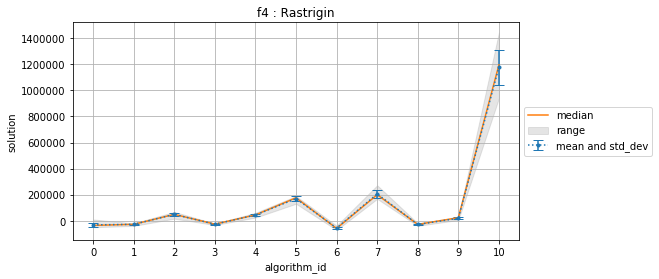

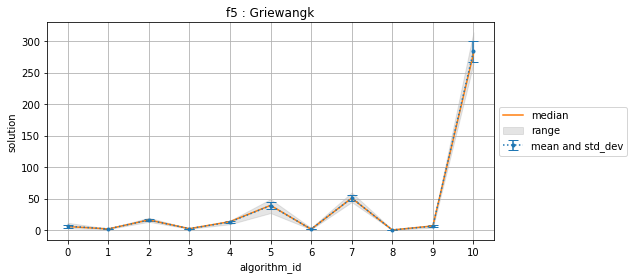

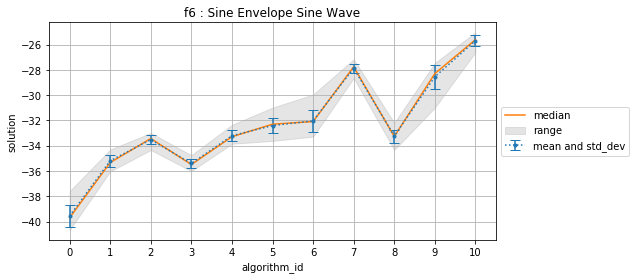

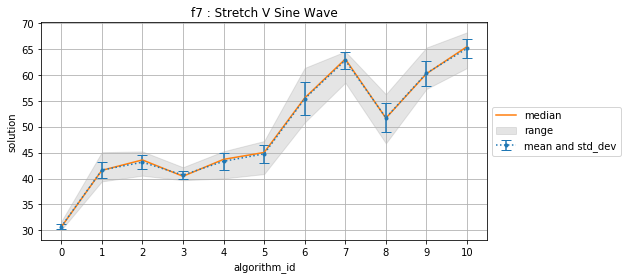

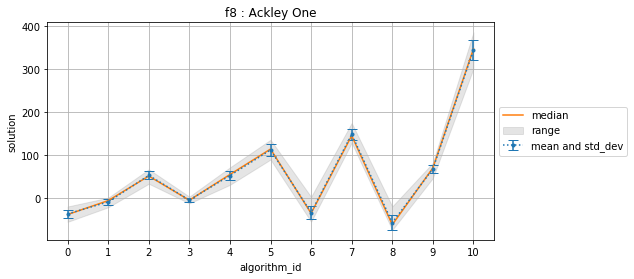

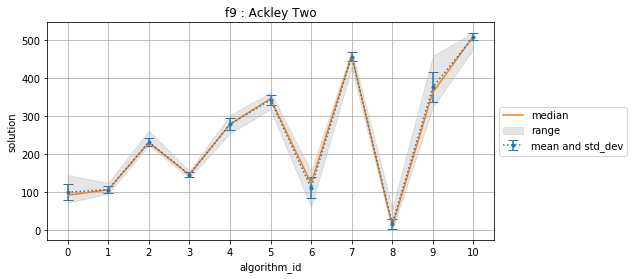

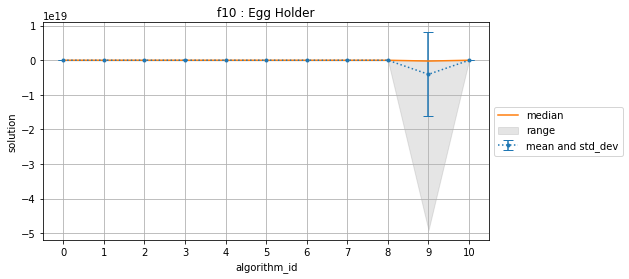

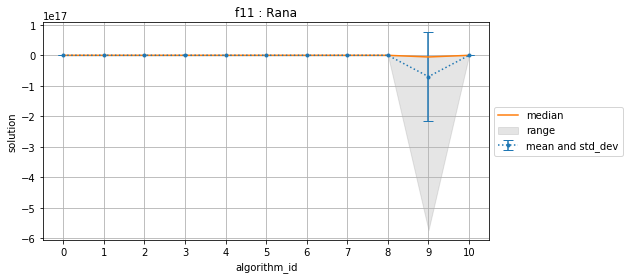

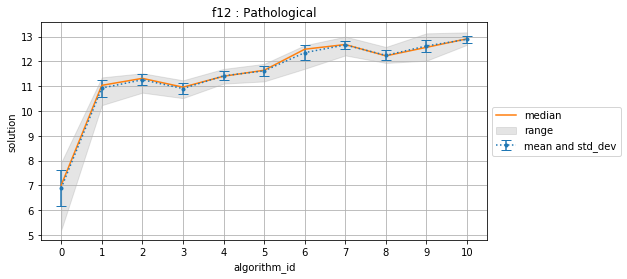

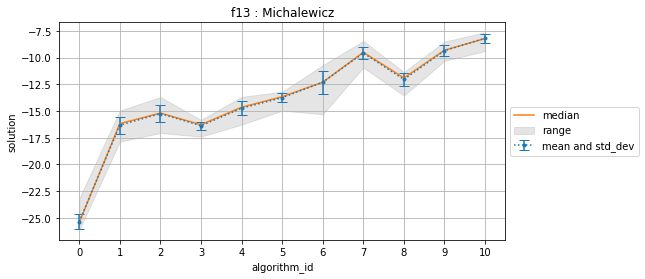

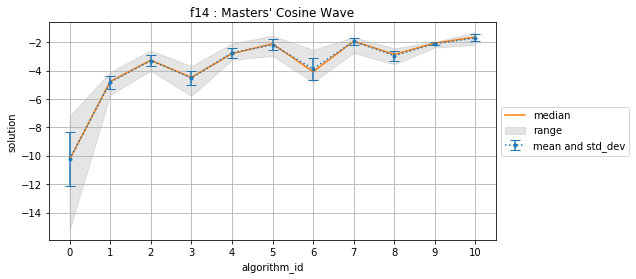

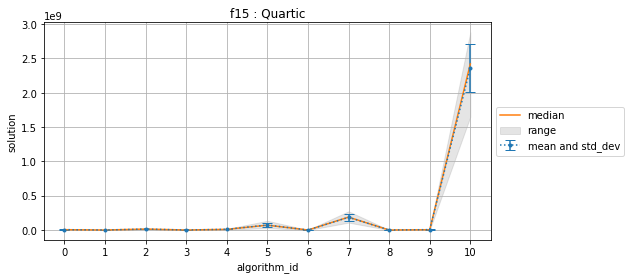

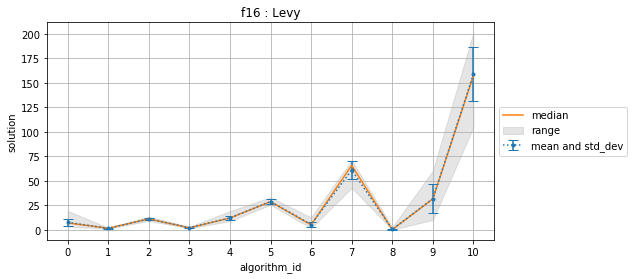

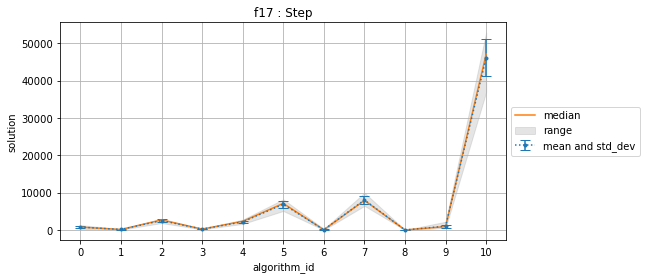

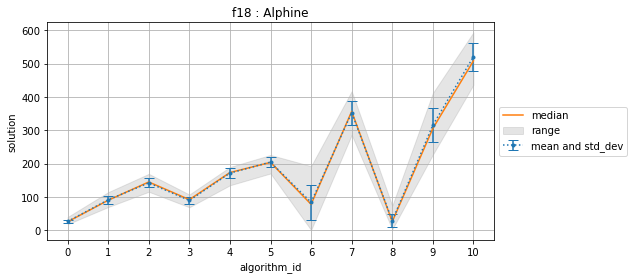

In [39]:
test.plot()

In [16]:
test.solution_df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.0,8.675160e+02,6.118350e+02,2.295730e+03,9.370560e+02,1151,-3.866130e+02,1.909110e+03
10,0,2,10,30,-100,100.0,7.897560e+02,2.366870e+02,7.738830e+02,7.112580e+02,385,4.971750e+02,1.271060e+03
11,0,3,10,30,-100,100.0,4.994730e+07,3.915200e+07,1.049770e+08,2.978820e+07,453,7.663900e+06,1.126410e+08
12,0,4,10,30,-30,30.0,-2.971600e+04,1.216750e+04,4.390320e+04,-3.013080e+04,970,-4.717460e+04,-3.271430e+03
13,0,5,10,30,-500,500.0,5.421390e+00,2.424430e+00,7.625900e+00,4.855610e+00,1160,2.805180e+00,1.043110e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,10,14,10,30,-30,30.0,-1.585400e+00,1.451080e-01,4.591490e-01,-1.548040e+00,1678,-1.872340e+00,-1.413190e+00
24,10,15,10,30,-100,100.0,2.216240e+09,4.240700e+08,1.436090e+09,2.287790e+09,519,1.484220e+09,2.920310e+09
25,10,16,10,30,-10,10.0,1.613190e+02,1.799130e+01,4.990340e+01,1.608560e+02,2387,1.383090e+02,1.882120e+02
26,10,17,10,30,-100,100.0,4.228910e+04,2.902830e+03,9.429780e+03,4.151850e+04,478,3.824620e+04,4.767590e+04


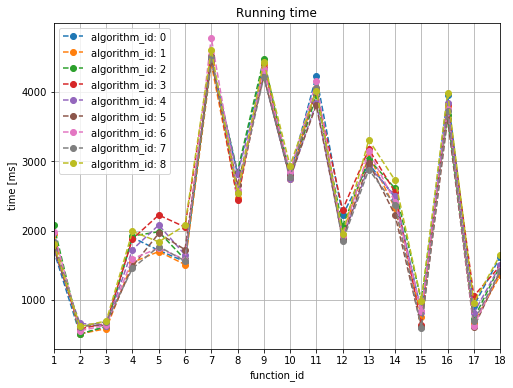

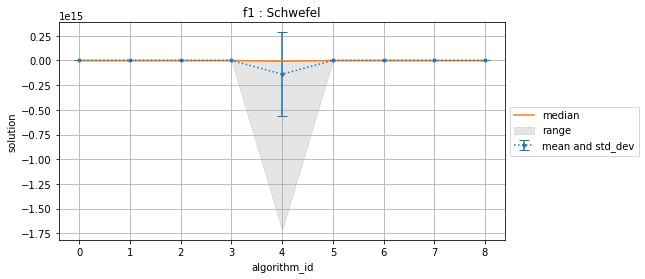

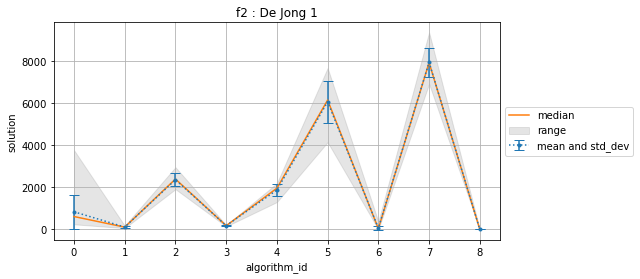

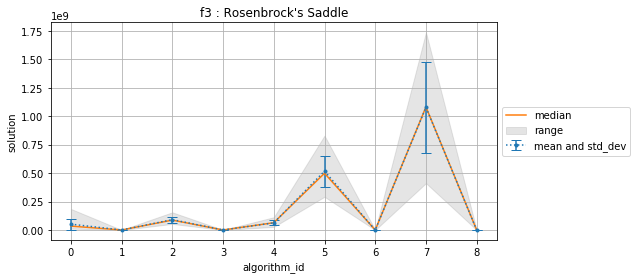

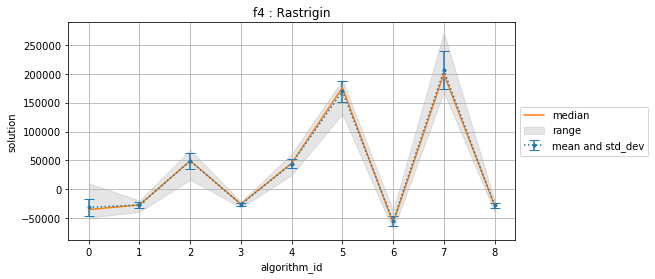

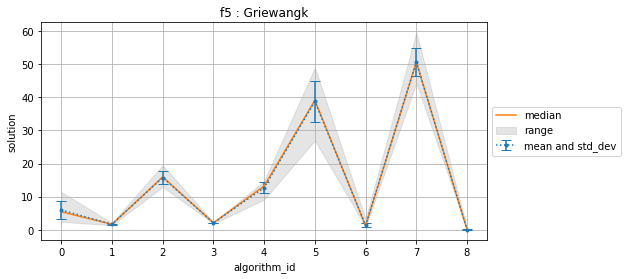

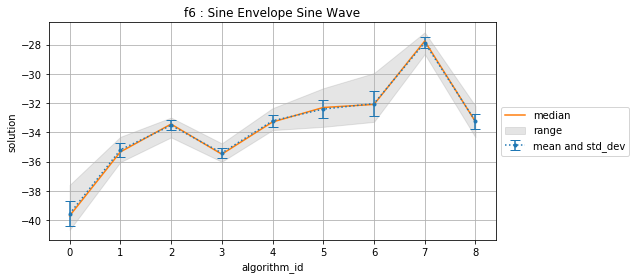

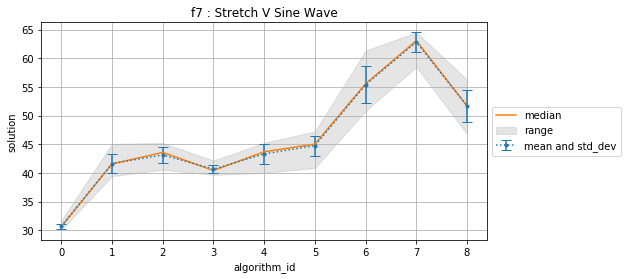

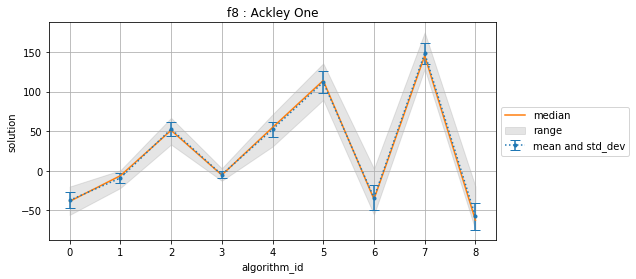

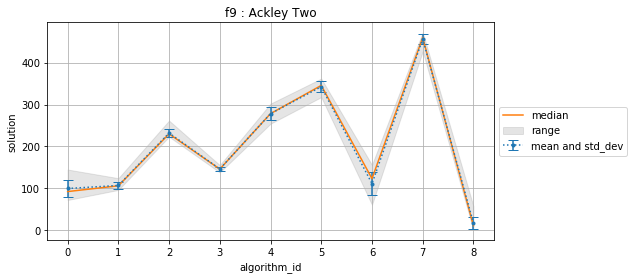

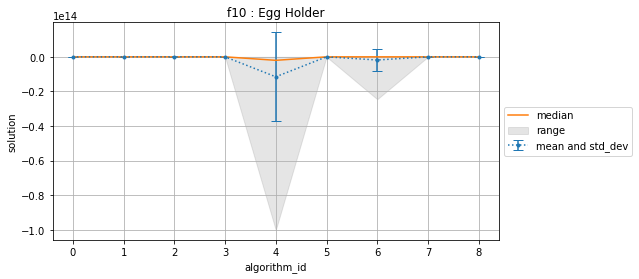

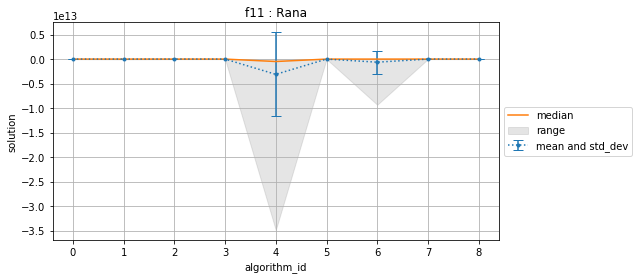

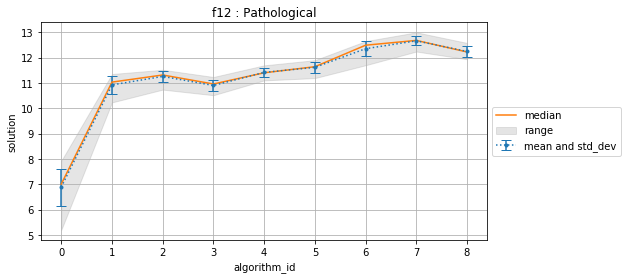

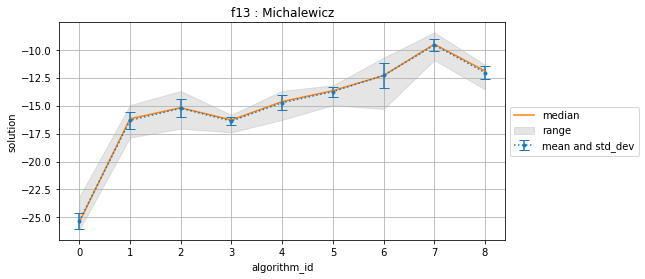

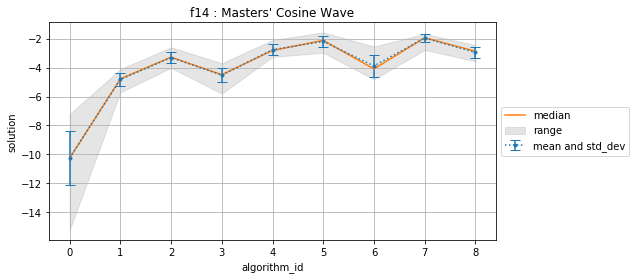

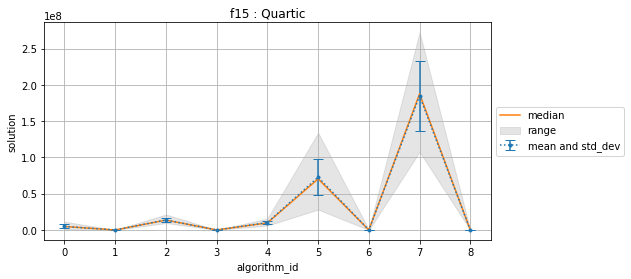

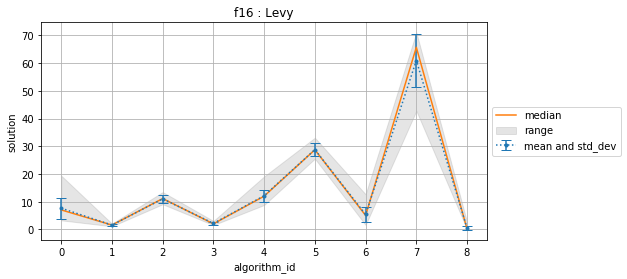

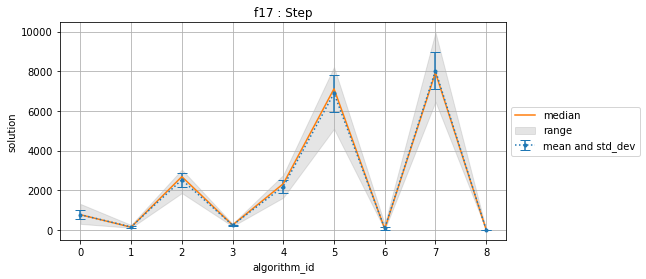

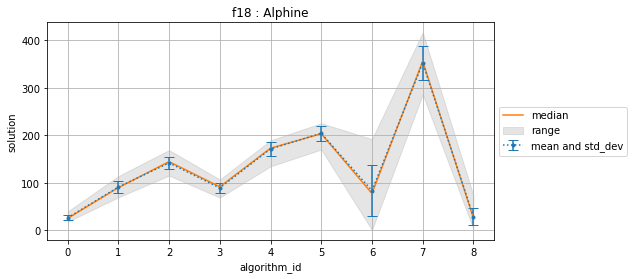

In [47]:
        df=pd.read_csv('solutions.csv',index_col=False)
        df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
        
        #delete 10
        df = df[df["algorithm_id"]!=10]
        df = df[df["algorithm_id"]!=9]
        #-----------plot running time
        fig, ax = plt.subplots(figsize=(8,6))
        for label, data in df.groupby('algorithm_id'):
            data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
        plt.ylabel('time [ms]')    
        plt.legend()
        plt.grid()
        plt.title('Running time')
        
   
        #---------plot statistics
        for id, data in df.groupby('function_id'):
            fig, ax = plt.subplots(figsize=(8,4))
            plt.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
            plt.plot(data['algorithm_id'],data['median'],label='median')
            plt.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
            plt.xticks(data['algorithm_id'])
            plt.title("f%d : %s"%(id, test.f_param_list_name[id-1]))
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xlabel('algorithm_id')
            plt.ylabel('solution')
            plt.grid()
        

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,15,30,-512,512.0,1.085680e+03,4.695970e+02,1.644110e+03,1.238590e+03,1713,1.814410e+02,1.825550e+03
10,0,2,15,30,-100,100.0,8.401170e+02,8.179540e+02,3.526910e+03,6.138450e+02,510,2.451570e+02,3.772060e+03
11,0,3,15,30,-100,100.0,5.152420e+07,4.887160e+07,1.733090e+08,3.437060e+07,613,1.204460e+07,1.853530e+08
12,0,4,15,30,-30,30.0,-3.138760e+04,1.426900e+04,5.963400e+04,-3.526410e+04,1900,-4.947800e+04,1.015610e+04
13,0,5,15,30,-500,500.0,6.003480e+00,2.703510e+00,8.982840e+00,5.473660e+00,1714,2.456760e+00,1.143960e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,9,14,15,30,-30,30.0,-2.116300e+00,1.060240e-01,4.032830e-01,-2.072040e+00,2766,-2.380280e+00,-1.976990e+00
186,9,15,15,30,-100,100.0,5.642250e+06,3.530210e+06,1.343590e+07,4.279840e+06,746,2.116270e+06,1.555220e+07
187,9,16,15,30,-10,10.0,3.175170e+01,1.472830e+01,5.018800e+01,3.156590e+01,3920,1.004350e+01,6.023150e+01
188,9,17,15,30,-100,100.0,1.017280e+03,4.191060e+02,1.642740e+03,9.036190e+02,729,5.656220e+02,2.208360e+03
